## import & key parameters

In [3]:
# env = tf
import finnhub
from transformers import pipeline
import time
from datetime import date, timedelta
import pandas as pd
import numpy as np

# грузим модель с HuggingFace
sentiment_analysis = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")
finnhub_client = finnhub.Client(api_key="c7au85qad3ia366fjdng")

2022-01-20 13:30:25.354316: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-20 13:30:25.354751: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at siebert/sentiment-roberta-large-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [2]:
# check if GPU working
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Подготовительные функции

stock news

In [ ]:
# Функиця скачивания новостей
def get_news(stock_ticker, start_date, interval):
    time_shift=interval+1
    aggreg_news=[]    
    while start_date <= date.today():
        finish_date = start_date + timedelta(interval)
        # долбимся не менее 10 раз
        k = 10
        while k>0:
            try:
                news_4period = finnhub_client.company_news(stock_ticker, _from=str(start_date), to=str(finish_date))
                k = 0
            except:
                k -= 1
        aggreg_news.extend(news_4period)
        start_date += timedelta(time_shift)
        time.sleep(1) #чтобы не блокировал API (иначе пишет, что лимит достигнут)
    return aggreg_news

In [ ]:
# скачиваем новости (c помощью get_news) и готовим для Roberta
def prepare_news(stock_ticker, stock_name, start_date, interval):
    # достаем c FinnHub новости по конкретной акции с опред дня до сегодня
    finhub_news=get_news(stock_ticker, start_date, interval)
    # из словаря в dataframe
    df_news = pd.DataFrame(finhub_news)
    # перевод в норм формат даты (+0000). dt.date - чтобы сохранить только дату.
    df_news['date'] = pd.to_datetime(df_news['datetime'], unit='s').dt.date
    # соединяем заголовок и саммари
    df_news['head_sum'] = df_news[['headline', 'summary']].apply(lambda x: '. '.join(x.astype(str)), axis=1)
    df_news.to_csv("data/all_news - %s - %s - %s.csv" %(stock_ticker, stock_name, start_date))
    # оставляем только новости с названием компании в заголовке
    df_news = df_news[df_news['head_sum'].str.contains(stock_name)]
    df_news.to_csv("data/filtered_news - %s - %s - %s.csv" %(stock_ticker, stock_name, start_date))
    return df_news

In [ ]:
def estim_news_sa(df_news):
    # прогоняем новости через Roberta (до 2х часов с лишним на массиве в 10тыс+ новостей). Возвращает list.
    # может ругаться на длину новостей (не более 512 токенов). Но таких единицы. Потом надо поставить ограничитель. Если в новости ничен
    news_sent = sentiment_analysis(df_news['head_sum'].fillna('Neutral').tolist())
    # соединяем даты и оценки новостей от Роберты и превращаем в датафрейм.
    df_news_sent = pd.concat([pd.DataFrame(news_sent), df_news[['date', 'head_sum']].reset_index(drop=True)], axis=1)
    df_news_sent.to_csv("data/sent_news - %s - %s - %s.csv" %(stock_ticker, stock_name, start_date))
    # высчитываем N_news и Pos_share через pivot таблицу вида: дата * label, значения = кол-во новостей
    stock_sent_dates = pd.pivot_table(df_news_sent \
                    , values='head_sum' \
                    , index='date', columns='label'
                    , aggfunc=np.count_nonzero
                    , observed=True)
    # может выдавать ошибку на наличе столбца 'POSITIVE'. Почему? 
    stock_sent_dates['pos_share'] = stock_sent_dates['POSITIVE'].fillna(0) / \
                                    (stock_sent_dates['NEGATIVE'].fillna(0) + stock_sent_dates['POSITIVE'].fillna(0))
    stock_sent_dates['tot_news'] = stock_sent_dates['NEGATIVE'].fillna(0) + stock_sent_dates['POSITIVE'].fillna(0)
    # сохраняем новости с сентиментами
    stock_sent_dates.to_csv("data/sent_dates - %s - %s.csv" %(stock_ticker, start_date))
    return stock_sent_dates

stock prices & combine with news SA

In [ ]:
def get_stock_prices(stock_ticker, start_date):
    # переводим даты в Unix формат
    unix_start_date = time.mktime(start_date.timetuple())
    unix_finish_date = time.mktime(date.today().timetuple())
    # качаем цены из FinnHub. Если ошибка - делаем до 30 попыток. 
    k = 10
    while k>0:
        try:
            fin_stock_hist = finnhub_client.stock_candles(stock_ticker, 'D', int(unix_start_date), int(unix_finish_date))
            k = 0
        except:
            time.sleep(0.5)
            k -= 1
    # переводим в датафрейм
    df_stock_price = pd.DataFrame(fin_stock_hist)
    # переводим дату в норм формат
    df_stock_price['date'] = pd.to_datetime(df_stock_price['t'], unit='s').dt.date
    # сохраняем цены
    df_stock_price.to_csv("data/prices - %s - %s.csv" %(stock_ticker, start_date))
    return df_stock_price

In [ ]:
def combine_stock_data(df_stock_price, stock_sent_dates):
    # соединяем цены с новостями
    df_stock_price_n_sent = df_stock_price.merge(stock_sent_dates, on='date')
    # меняем порядок, оставляем только нужные колонки
    df_stock_price_n_sent = df_stock_price_n_sent[['date', 'o', 'c', 'h', 'l', 'v', 'POSITIVE', 'NEGATIVE']]
    return df_stock_price_n_sent

NASDAQ

In [23]:
finnhub_client.symbol_lookup('nasdaq 100')
# ^NDX

{'count': 22,
 'result': [{'description': 'Nasdaq 100',
   'displaySymbol': '^NDX',
   'symbol': '^NDX',
   'type': 'Indice'},
  {'description': 'MTF SAL NASDAQ 100',
   'displaySymbol': 'MTFF95.TA',
   'symbol': 'MTFF95.TA',
   'type': 'ETP'},
  {'description': 'MORE SAL NASDAQ 100',
   'displaySymbol': 'MORES3.TA',
   'symbol': 'MORES3.TA',
   'type': 'ETP'},
  {'description': 'LYXOR NASDAQ 100-ACC',
   'displaySymbol': 'NASD.L',
   'symbol': 'NASD.L',
   'type': 'ETP'},
  {'description': 'LYXOR NASDAQ 100-ACC',
   'displaySymbol': 'LYMS.BE',
   'symbol': 'LYMS.BE',
   'type': 'ETP'},
  {'description': 'LYXOR NASDAQ 100-ACC',
   'displaySymbol': 'LYMS.DU',
   'symbol': 'LYMS.DU',
   'type': 'ETP'},
  {'description': 'LYXOR NASDAQ 100-ACC',
   'displaySymbol': 'NASL.L',
   'symbol': 'NASL.L',
   'type': 'ETP'},
  {'description': 'LYXOR NASDAQ 100-ACC',
   'displaySymbol': 'LYMS.MU',
   'symbol': 'LYMS.MU',
   'type': 'ETP'},
  {'description': 'LYXOR NASDAQ 100-ACC',
   'displaySymbol'

In [25]:
get_stock_prices(stock_ticker, start_date)

UnboundLocalError: local variable 'fin_stock_hist' referenced before assignment

## For stock data load & prep 

In [ ]:
# run all functions - FOR 1 STOCK
stock_ticker = 'FISV' #тикер компании
stock_name = 'Fiserv' #по какому названию компании фильтровать заголовки (остальные удаляем)
start_date = date(2021, 2, 1)  # с какого дня (не больше года назад на бесплатном тарифе)
interval = 5 #дней за раз, не более 5-10, иначе API будет терять новости

df_news = prepare_news(stock_ticker, stock_name, start_date, interval)
stock_sent_dates = estim_news_sa(df_news)
df_stock_price = get_stock_prices(stock_ticker, start_date)
df_stock_price_n_sent = combine_stock_data(df_stock_price, stock_sent_dates)

#save stock data to file
df_stock_price_n_sent.to_csv("data/%s - %s.csv" %(stock_ticker, start_date))

In [10]:
# run all functions - ALL STOCKS FROM FILE
# stock_ticker = 'FISV' #тикер компании
# stock_name = 'Fiserv' #по какому названию компании фильтровать заголовки (остальные удаляем)
start_date = date(2021, 1, 13)  # с какого дня (не больше года назад на бесплатном тарифе)
interval = 5 #дней за раз (скачивание новостей с FinnHub), не более 5-10, иначе API будет терять новости

for i in pd.read_csv('stocks_list1.csv')[['Company_short', 'Ticker']].values.tolist():
    stock_ticker = i[1]
    stock_name = i[0]
    df_news = prepare_news(stock_ticker, stock_name, start_date, interval)
    stock_sent_dates = estim_news_sa(df_news)
    df_stock_price = get_stock_prices(stock_ticker, start_date)
    df_stock_price_n_sent = combine_stock_data(df_stock_price, stock_sent_dates)

    #save stock data to file
    df_stock_price_n_sent.to_csv("data/%s - %s.csv" %(stock_ticker, start_date))

Token indices sequence length is longer than the specified maximum sequence length for this model (661 > 512). Running this sequence through the model will result in indexing errors


KeyboardInterrupt: 

## Load all history prices from YFinance

In [ ]:
# env = base
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# load Nasdaq100 stocks history
for i in pd.read_csv('stocks_list1.csv')[['Ticker']].values.tolist():
    stock_ticker = i[0]
    yf_stock = yf.Ticker(stock_ticker)
    yf_stock.history(period="max").to_csv("long_history/%s - history.csv" %(stock_ticker))

In [ ]:
NVDA_hist = pd.read_csv('long_hstory/NVDA - history.csv')

In [ ]:
NVDA_hist[NVDA_hist['Stock Splits']>0]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
361,2000-06-27,3.148154,3.200783,2.643397,2.727125,60460800.0,0.0,2.0
665,2001-09-12,NaN,NaN,NaN,NaN,NaN,0.0,2.0
1814,2006-04-07,4.666541,4.707878,4.582335,4.674196,68267400.0,0.0,2.0
2172,2007-09-11,7.870196,8.001097,7.787520,7.941388,40542400.0,0.0,1.5
5660,2021-07-20,187.244063,188.323742,181.585750,186.064407,43468700.0,0.0,4.0


In [ ]:
# стоимость акций не меняется после дробления. Похоже Yahoo аджастирует историю цен.
NVDA_hist[NVDA_hist['Date']>'2021-07-15'].head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
5658,2021-07-16,190.248151,191.512787,180.676014,181.555756,68822400.0,0.0,0.0
5659,2021-07-19,179.098973,190.363108,178.601624,187.741394,74906000.0,0.0,0.0
5660,2021-07-20,187.244063,188.323742,181.585750,186.064407,43468700.0,0.0,4.0
5661,2021-07-21,188.763616,195.211687,187.364025,194.042038,37101700.0,0.0,0.0
5662,2021-07-22,196.361322,198.810587,192.702412,195.881470,32382600.0,0.0,0.0


In [ ]:
stock_history.head(4)

,Unnamed: 0,date,o,c,h,l,v,POSITIVE,NEGATIVE
0,0,2021-01-19,127.78,127.83,128.71,126.938,90757329,23.0,9.0
1,1,2021-01-20,128.66,132.03,132.49,128.550,104319489,11.0,5.0
2,2,2021-01-21,133.80,136.87,139.67,133.590,120529544,17.0,20.0
3,3,2021-01-22,136.28,139.07,139.85,135.020,114459360,17.0,5.0


## Добавляем классы акций

In [ ]:
stock_list = pd.read_csv('stocks_list(no MRNA & LCID).csv')
problem_list = []
for index, row in stock_list.iterrows():
    stock_ticker = row['Ticker']
    vol_level = row['volat_level']
    # sub_ind = row['GICS Sub-Industry']
    # sector = row['GICS Sector']
    try:
        df = pd.read_csv('data/%s - 2021-01-13.csv' %stock_ticker)
        df['volat_level']= vol_level
        df.to_csv('data/%s - 2021-01-13.csv' %stock_ticker)
    except:
        problem_list.append(stock_ticker)


In [ ]:
problem_list

['GOOG']

In [ ]:
df

,Unnamed: 0,date,o,c,h,l,v,POSITIVE,NEGATIVE,volat_level
0,0,2021-02-25,204.00,195.79,210.91,194.3400,2557498,1.0,NaN,0.151182
1,1,2021-02-26,213.10,205.03,224.08,197.0821,3721972,2.0,NaN,0.151182
2,2,2021-03-01,208.75,210.16,211.14,202.1800,1918108,1.0,NaN,0.151182
3,3,2021-03-02,212.00,202.61,212.00,202.2700,1788701,1.0,NaN,0.151182
4,4,2021-03-03,202.11,187.83,202.12,187.4600,2703792,1.0,NaN,0.151182
...,...,...,...,...,...,...,...,...,...,...
146,146,2022-01-07,258.38,261.53,268.36,254.3510,1696005,2.0,NaN,0.151182
147,147,2022-01-10,254.50,275.65,276.02,249.0100,4333283,1.0,NaN,0.151182
148,148,2022-01-11,270.45,277.53,281.37,267.3304,1517925,1.0,NaN,0.151182
149,149,2022-01-12,283.11,273.98,288.61,272.8800,1881002,2.0,NaN,0.151182


In [ ]:
# удаляем лишние столбцы
stock_list = pd.read_csv('stocks_list(no MRNA & LCID & GOOG).csv')
problem_list = []
for index, row in stock_list.iterrows():
    stock_ticker = row['Ticker']
    df = pd.read_csv('data/%s - 2021-01-13.csv' %stock_ticker)
    df.drop('volat_class', axis=1, inplace=True, errors='ignore')
    df.drop('GICS Sub-Industry', axis=1, inplace=True, errors='ignore')
    df.drop('GICS Sector', axis=1, inplace=True, errors='ignore')
    df.drop(list(df.filter(regex = 'Unnamed')), axis=1, inplace=True, errors='ignore')
    df.to_csv('data/%s - 2021-01-13.csv' %stock_ticker)

In [ ]:
stock_list

,Company_short,Ticker,Company,GICS Sector,GICS Sub-Industry,volat_level
0,Activision,ATVI,Activision Blizzard,Communication Services,Interactive Home Entertainment,0.079320
1,Adobe,ADBE,Adobe,Information Technology,Application Software,0.123115
2,Advanced,AMD,Advanced Micro Devices,Information Technology,Semiconductors,0.148988
3,Airbnb,ABNB,Airbnb,Consumer Discretionary,Internet & Direct Marketing Retail,0.101045
4,Align,ALGN,Align Technology,Health Care,Health Care Supplies,0.106628
...,...,...,...,...,...,...
94,Workday,WDAY,Workday,Information Technology,Application Software,0.093510
95,Xcel,XEL,Xcel Energy,Utilities,Multi-Utilities,0.054979
96,Xilinx,XLNX,Xilinx,Information Technology,Semiconductors,0.126333
97,Zoom,ZM,Zoom Video Communications,Information Technology,Application Software,0.117948


In [ ]:
stock_ticker = 'AAPL'
df = pd.read_csv('data/%s - 2021-01-13.csv' %stock_ticker)
df.drop('volat_class', axis=1, inplace=True, errors='ignore')
df.drop('GICS Sub-Industry', axis=1, inplace=True, errors='ignore')
df.drop('GICS Sector', axis=1, inplace=True, errors='ignore')
df.drop(list(df.filter(regex = 'Unnamed')), axis=1, inplace=True, errors='ignore')
df.to_csv('data/%s - 2021-01-13.csv' %stock_ticker)

## Vader

In [30]:
pip install vaderSentiment

     |████████████████████████████████| 125 kB 839 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [1]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
sentences = ["VADER is smart, handsome, and funny.",  # positive sentence example
             "VADER is smart, handsome, and funny!",  # punctuation emphasis handled correctly (sentiment intensity adjusted)
             "VADER is very smart, handsome, and funny.", # booster words handled correctly (sentiment intensity adjusted)
             "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
             "VADER is VERY SMART, handsome, and FUNNY!!!", # combination of signals - VADER appropriately adjusts intensity
             "VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!", # booster words & punctuation make this close to ceiling for score
             "VADER is not smart, handsome, nor funny.",  # negation sentence example
             "The book was good.",  # positive sentence
             "At least it isn't a horrible book.",  # negated negative sentence with contraction
             "The book was only kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
             "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
             "Today SUX!",  # negative slang with capitalization emphasis
             "Today only kinda sux! But I'll get by, lol", # mixed sentiment example with slang and constrastive conjunction "but"
             "Make sure you :) or :D today!",  # emoticons handled
             "Catch utf-8 emoji such as such as 💘 and 💋 and 😁",  # emojis handled
             "Not bad at all"  # Capitalized negation
             ]

analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

VADER is smart, handsome, and funny.----------------------------- {'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}
VADER is smart, handsome, and funny!----------------------------- {'neg': 0.0, 'neu': 0.248, 'pos': 0.752, 'compound': 0.8439}
VADER is very smart, handsome, and funny.------------------------ {'neg': 0.0, 'neu': 0.299, 'pos': 0.701, 'compound': 0.8545}
VADER is VERY SMART, handsome, and FUNNY.------------------------ {'neg': 0.0, 'neu': 0.246, 'pos': 0.754, 'compound': 0.9227}
VADER is VERY SMART, handsome, and FUNNY!!!---------------------- {'neg': 0.0, 'neu': 0.233, 'pos': 0.767, 'compound': 0.9342}
VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!--------- {'neg': 0.0, 'neu': 0.294, 'pos': 0.706, 'compound': 0.9469}
VADER is not smart, handsome, nor funny.------------------------- {'neg': 0.646, 'neu': 0.354, 'pos': 0.0, 'compound': -0.7424}
The book was good.----------------------------------------------- {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'co

In [56]:
df=pd.read_csv('/Users/oslikdau/Documents/GitHub/ds_bootcamp/Project/data/!sent_news/sent_news - JD - JD.com - 2021-01-13.csv')
sentences = df['head_sum'].values.tolist()

In [57]:
vs = analyzer.polarity_scores(sentence[0])
print("{:-<65} {}".format(sentence, str(vs)))

Kraft Heinz Names Dafne Hefner as N. America Zone Chief Strategy and Transformation Officer. By Michael Dabaie Kraft Heinz Co. said it named Dafne Hefner to the newly created role of chief strategy and transformation officer for North America. Ms. Hefner is being hired to help... | January 12, 2022 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [58]:
analyzer = SentimentIntensityAnalyzer()
vader_sent = []
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    vader_sent.append(vs)

In [59]:
vader_bert = pd.concat([df, pd.DataFrame(vader_sent)], axis=1)
vader_bert[(vader_bert['label']=='POSITIVE') & (vader_bert['compound']<0)].shape[0] / vader_bert.shape[0]

0.06140350877192982

In [60]:
vader_bert[(vader_bert['label']=='NEGATIVE') & (vader_bert['compound']>0)].shape[0] / vader_bert.shape[0]

0.13815789473684212

## Recommendations

In [62]:
pd.DataFrame(finnhub_client.recommendation_trends('AAPL'))

,buy,hold,period,sell,strongBuy,strongSell,symbol
0,25,7,2022-01-01,0,17,0,AAPL
1,24,8,2021-12-01,0,16,0,AAPL
2,24,8,2021-11-01,0,16,0,AAPL
3,23,9,2021-10-01,0,16,0,AAPL


In [177]:
pd.DataFrame(finnhub_client.recommendation_trends('NFLX'))

,buy,hold,period,sell,strongBuy,strongSell,symbol
0,22,10,2022-01-01,2,16,1,NFLX
1,23,9,2021-12-01,2,16,1,NFLX
2,23,9,2021-11-01,2,16,1,NFLX
3,23,9,2021-10-01,3,15,1,NFLX


In [122]:
stocks_reco = pd.DataFrame()
for i in pd.read_csv('stocks_list(no MRNA & LCID & GOOG).csv')[['Ticker']].values.tolist():
    stock_ticker = i[0]
    k = 10
    while k>0:
        try:
            stock_reco = pd.DataFrame(finnhub_client.recommendation_trends(stock_ticker))
            stocks_reco = pd.concat([stocks_reco, stock_reco])
            k = 0
        except:
            time.sleep(0.5)
            k -= 1

In [144]:
stocks_reco['to buy'] = stocks_reco['buy'] + stocks_reco['strongBuy']
stocks_reco['to sell'] = stocks_reco['sell'] + stocks_reco['strongSell']
stocks_reco.drop(['sell', 'strongSell', 'buy', 'strongBuy'], axis=1, inplace=True)


KeyError: 'buy'

In [146]:
stocks_reco = stocks_reco[stocks_reco['period']=='2022-01-01']

собрать sents новостей за вчера

In [79]:
import glob

In [125]:
directory = 'data/!sent_dates/*.csv'

all_sents = pd.DataFrame()
for fname in glob.glob(directory):
    df=pd.read_csv(fname)
    df['symbol'] = fname[30:34]
    all_sents = pd.concat([all_sents, df.iloc[[-1]]], axis=0)

In [139]:
all_sents

,date,NEGATIVE,POSITIVE,pos_share,tot_news,symbol
260,2022-01-12,1.0,1.0,0.500000,2.0,TMUS
162,2022-01-13,NaN,2.0,1.000000,2.0,ZS -
51,2022-01-07,1.0,NaN,0.000000,1.0,IDXX
191,2022-01-12,NaN,1.0,1.000000,1.0,SPLK
215,2022-01-12,NaN,1.0,1.000000,1.0,ORLY
...,...,...,...,...,...,...
175,2022-01-13,NaN,1.0,1.000000,1.0,ASML
227,2022-01-12,NaN,2.0,1.000000,2.0,XEL
289,2022-01-13,1.0,2.0,0.666667,3.0,SBUX
238,2022-01-13,1.0,17.0,0.944444,18.0,MNST


In [158]:
# combine recos & sent news
for_bot = all_sents.merge(stocks_reco, on='symbol')


,date,NEGATIVE,POSITIVE,pos_share,tot_news,symbol,hold,period,to buy,to sell
26,2022-01-12,1.0,NaN,0.0,1.0,FAST,10,2022-01-01,3,7
51,2022-01-11,NaN,2.0,1.0,2.0,FISV,6,2022-01-01,35,0
59,2022-01-13,NaN,1.0,1.0,1.0,FTNT,13,2022-01-01,23,1


In [161]:
all_sents[all_sents['symbol'].str.startswith('F')]

,date,NEGATIVE,POSITIVE,pos_share,tot_news,symbol
100,2022-01-14,3.0,NaN,0.0,3.0,FB -
223,2022-01-12,1.0,NaN,0.0,1.0,FAST
241,2022-01-11,NaN,2.0,1.0,2.0,FISV
240,2022-01-13,NaN,1.0,1.0,1.0,FTNT


In [152]:
col = ['symbol',
 'date',
 'NEGATIVE',
 'POSITIVE',
 'pos_share',
 'tot_news',
 'period',
 'hold',
 'to buy',
 'to sell']

for_bot = for_bot[col]
for_bot.sort_values('symbol', inplace=True)

In [154]:
for_bot['pos_share'] = for_bot['pos_share']*100

,symbol,date,NEGATIVE,POSITIVE,pos_share,tot_news,period,hold,to buy,to sell
56,AAPL,2022-01-13,NaN,2.0,100.0,2.0,2022-01-01,7,42,0
45,ABNB,2022-01-17,NaN,1.0,100.0,1.0,2022-01-01,18,26,2
63,ADBE,2022-01-15,1.0,1.0,50.0,2.0,2022-01-01,6,32,0
4,ADSK,2022-01-12,1.0,1.0,50.0,2.0,2022-01-01,7,22,1
19,AMAT,2022-01-12,NaN,1.0,100.0,1.0,2022-01-01,9,31,0
...,...,...,...,...,...,...,...,...,...,...
58,VRSK,2022-01-07,1.0,NaN,0.0,1.0,2022-01-01,7,14,0
48,VRSN,2022-01-04,NaN,1.0,100.0,1.0,2022-01-01,4,7,0
27,VRTX,2022-01-13,NaN,2.0,100.0,2.0,2022-01-01,8,26,2
32,WDAY,2022-01-13,NaN,2.0,100.0,2.0,2022-01-01,5,37,0


In [155]:
for_bot.to_csv('news_recos_4bot.csv')

In [72]:
stocks_reco = pd.DataFrame()

stock_ticker = 'MSFT'
stock_reco = pd.DataFrame(finnhub_client.recommendation_trends(stock_ticker))
stocks_reco = pd.concat([stocks_reco, stock_reco])

stock_ticker = 'AAPL'
stock_reco = pd.DataFrame(finnhub_client.recommendation_trends(stock_ticker))
stocks_reco = pd.concat([stocks_reco, stock_reco])

stocks_reco

,buy,hold,period,sell,strongBuy,strongSell,symbol
0,29,3,2022-01-01,0,21,0,MSFT
1,27,3,2021-12-01,0,20,0,MSFT
2,25,3,2021-11-01,0,20,0,MSFT
3,25,4,2021-10-01,0,19,0,MSFT
0,25,7,2022-01-01,0,17,0,AAPL
1,24,8,2021-12-01,0,16,0,AAPL
2,24,8,2021-11-01,0,16,0,AAPL
3,23,9,2021-10-01,0,16,0,AAPL


## social media

In [ ]:
socmed = {}
socmed['AAPL'] = finnhub_client.stock_social_sentiment('AAPL')[0]
socmed['MSFT'] = finnhub_client.stock_social_sentiment('MSFT')[0]
pd.DataFrame(socmed)

KeyError: 0

In [ ]:
start_date = date(2021, 2, 1) 
finish_date = date(2022, 1, 1) 
finnhub_client.stock_social_sentiment('AAPL', _from=str(start_date), to=str(finish_date)) 

{'reddit': [{'atTime': '2022-01-01 00:00:00',
   'mention': 5,
   'positiveScore': 0,
   'negativeScore': 0,
   'positiveMention': 0,
   'negativeMention': 0,
   'score': 0},
  {'atTime': '2021-12-31 23:00:00',
   'mention': 5,
   'positiveScore': 0.82222354,
   'negativeScore': 0.9744711,
   'positiveMention': 1,
   'negativeMention': 3,
   'score': -0.52529744},
  {'atTime': '2021-12-31 22:00:00',
   'mention': 6,
   'positiveScore': 0,
   'negativeScore': 0.9413028,
   'positiveMention': 0,
   'negativeMention': 1,
   'score': -0.9413028},
  {'atTime': '2021-12-31 21:00:00',
   'mention': 9,
   'positiveScore': 0.9179041,
   'negativeScore': 0,
   'positiveMention': 1,
   'negativeMention': 0,
   'score': 0.9179041},
  {'atTime': '2021-12-31 20:00:00',
   'mention': 17,
   'positiveScore': 0.97187175,
   'negativeScore': 0.99269575,
   'positiveMention': 2,
   'negativeMention': 4,
   'score': -0.33783991666666663},
  {'atTime': '2021-12-31 19:00:00',
   'mention': 4,
   'positiveSc

In [166]:
tesla_news = pd.read_csv('data/!sent_dates/sent_dates - TSLA - 2021-01-13.csv')[-15:]

In [172]:
tesla_news = tesla_news.drop(['pos_share', 'tot_news'], axis=1)

In [174]:
tesla_news['NEGATIVE'] = tesla_news['NEGATIVE']*(-1)

<AxesSubplot:>

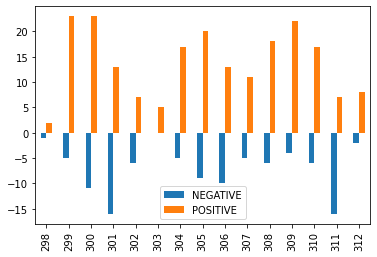

In [175]:
tesla_news.plot.bar()